# PacketPatrolAI - AI based Network Attack Detection

Luca Di Bello (luca.dibello@student.supsi.ch) - SUPSI - 2021

## Dataset description

The dataset used for this project is written in the NetFlow V9 format (format by Cisco, documentation available [here](https://www.cisco.com/en/US/technologies/tk648/tk362/technologies_white_paper09186a00800a3db9.html)). The dataset is composed by two files:

* **train_set**: ~2 million flows, used for training the model
* **test_set**: ~4 million flows, used for testing the model

### Columns
* **FLOW_ID**: A unique identifier for the flow
* **PROTOCOL_MAP**: A string representing the protocol used in the flow, possible values include "ICMP", "TCP", "UDP", "IGMP", "GRE", "ESP", "AH", "EIGRP", "OSPF", "PIM", "IPV6-ICMP", "IPV6-IP", "IPV6-ROUTE", "IPV6-FRAG", "IPV6-NONXT", "IPV6-OPTS", and others.
* **L4_SRC_PORT**: The source port number in the flow, possible values range from 0 to 65535.
* **IPV4_SRC_ADDR**: The source IPv4 address in the flow, represented as a string in dotted decimal notation (e.g., "192.168.0.1").
* **L4_DST_PORT**: The destination port number in the flow, possible values range from 0 to 65535.
* **IPV4_DST_ADDR**: The destination IPv4 address in the flow, represented as a string in dotted decimal notation (e.g., "192.168.0.2").
* **FIRST_SWITCHED**: The time at which the flow started, measured in seconds since the epoch (January 1, 1970).
* **FLOW_DURATION_MILLISECONDS**: The duration of the flow in milliseconds.
* **LAST_SWITCHED**: The time at which the flow ended, measured in seconds since the epoch (January 1, 1970).
* **PROTOCOL**: The protocol used in the flow, possible values include 1 (ICMP), 6 (TCP), 17 (UDP), and others.
* **TCP_FLAGS**: The TCP flags set in the flow, represented as a binary string (e.g., "100101").
* **TCP_WIN_MAX_IN**: The maximum advertised window size (in bytes) for incoming traffic.
* **TCP_WIN_MAX_OUT**: The maximum advertised window size (in bytes) for outgoing traffic.
* **TCP_WIN_MIN_IN**: The minimum advertised window size (in bytes) for incoming traffic.
* **TCP_WIN_MIN_OUT**: The minimum advertised window size (in bytes) for outgoing traffic.
* **TCP_WIN_MSS_IN**: The maximum segment size (in bytes) for incoming traffic.
* **TCP_WIN_SCALE_IN**: The window scale factor for incoming traffic.
* **TCP_WIN_SCALE_OUT**: The window scale factor for outgoing traffic.
* **SRC_TOS**: The Type of Service (ToS) value for the source IP address.
* **DST_TOS**: The Type of Service (ToS) value for the destination IP address.
* **TOTAL_FLOWS_EXP**: The total number of expected flows.
* **MIN_IP_PKT_LEN**: The minimum length (in bytes) of IP packets in the flow.
* **MAX_IP_PKT_LEN**: The maximum length (in bytes) of IP packets in the flow.
* **TOTAL_PKTS_EXP**: The total number of expected packets in the flow.
* **TOTAL_BYTES_EXP**: The total number of expected bytes in the flow.
* **IN_BYTES**: The number of bytes received in the flow.
* **IN_PKTS**: The number of packets received in the flow.
* **OUT_BYTES**: The number of bytes sent in the flow.
* **OUT_PKTS**: The number of packets sent in the flow.
* **ANALYSIS_TIMESTAMP**: The time at which the flow was analyzed, measured in seconds since the epoch (January 1, 1970).
* **ANOMALY**: A binary flag indicating whether the flow contains an anomaly (1 = true, 0 = false).
* **ALERT**: (<u>only available in training set</u>) The kind of attack that has been detected on the current flow. This are the possible values:
  - **None**: No attack has been detected
  - **Port scanning**: The flow is a port scanning attack 
  - **Denial of Service**: The flow is a DoS attack
  - **Malware**: The flow is a malware attack
* **ID**: A unique identifier for the flow.

## 1. Loading the datasets

In [2]:
# Load data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [3]:
# Load machine learning libraries
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
# Loading the data from the train and test files
train_df = pd.read_csv('data/train_net.csv')
test_df = pd.read_csv('data/test_net.csv')

## 2. Data Preprocessing

In [5]:
# Show information about the data
def printInfo(df):
    print('Dataframe shape: ', df.shape)
    print('Dataframe columns: ', df.columns)

print('==== Train data ====')
printInfo(train_df)
print()
print('==== Test data ====')
printInfo(test_df)

==== Train data ====
Dataframe shape:  (4217625, 33)
Dataframe columns:  Index(['FLOW_ID', 'PROTOCOL_MAP', 'L4_SRC_PORT', 'IPV4_SRC_ADDR',
       'L4_DST_PORT', 'IPV4_DST_ADDR', 'FIRST_SWITCHED',
       'FLOW_DURATION_MILLISECONDS', 'LAST_SWITCHED', 'PROTOCOL', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'TCP_WIN_MIN_IN',
       'TCP_WIN_MIN_OUT', 'TCP_WIN_MSS_IN', 'TCP_WIN_SCALE_IN',
       'TCP_WIN_SCALE_OUT', 'SRC_TOS', 'DST_TOS', 'TOTAL_FLOWS_EXP',
       'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'TOTAL_PKTS_EXP', 'TOTAL_BYTES_EXP',
       'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'ANALYSIS_TIMESTAMP',
       'ANOMALY', 'ALERT', 'ID'],
      dtype='object')

==== Test data ====
Dataframe shape:  (2077339, 32)
Dataframe columns:  Index(['FLOW_ID', 'PROTOCOL_MAP', 'L4_SRC_PORT', 'IPV4_SRC_ADDR',
       'L4_DST_PORT', 'IPV4_DST_ADDR', 'FIRST_SWITCHED',
       'FLOW_DURATION_MILLISECONDS', 'LAST_SWITCHED', 'PROTOCOL', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT'

In [6]:
train_df.head()

,FLOW_ID,PROTOCOL_MAP,L4_SRC_PORT,IPV4_SRC_ADDR,L4_DST_PORT,IPV4_DST_ADDR,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LAST_SWITCHED,PROTOCOL,...,TOTAL_PKTS_EXP,TOTAL_BYTES_EXP,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,ANALYSIS_TIMESTAMP,ANOMALY,ALERT,ID
0,372018590,udp,53950,10.114.232.40,53,10.114.226.5,1647760833,1,1647760833,17,...,0,0,165,2,275,2,1647760873,0.0,None,0
1,368604472,tcp,37914,10.114.241.166,38303,10.114.224.218,1647686725,1,1647686725,6,...,0,0,44,1,40,1,1647687338,0.0,Port Scanning,1
2,367513992,tcp,33216,10.114.241.166,18757,10.114.224.116,1647680044,0,1647680044,6,...,0,0,44,1,40,1,1647680115,1.0,Port Scanning,2
3,371997670,udp,48627,10.114.225.205,53,10.114.226.5,1647760172,0,1647760172,17,...,0,0,128,2,160,2,1647760207,0.0,None,3
4,374311119,udp,35939,10.114.225.205,53,10.114.226.5,1647780916,0,1647780916,17,...,0,0,172,2,300,2,1647780984,0.0,None,4


## 3. Data Analysis

### 3.1. Observing the distribution of the target variable

<Axes: xlabel='ALERT', ylabel='count'>

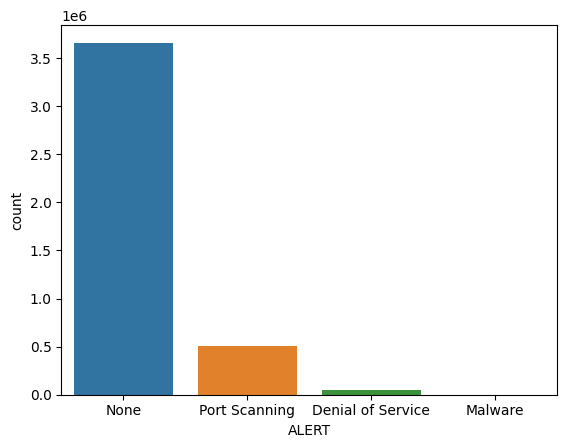

In [7]:
# Show the distribution of the target variable
sns.countplot(x='ALERT', data=train_df)

In [13]:
# Count the number of unique protocol_maps
train_df['PROTOCOL_MAP'].value_counts()

tcp          2099470
udp          1792273
icmp          324539
gre             1164
ipv6-icmp        156
skip              22
ipv6               1
Name: PROTOCOL_MAP, dtype: int64

<Axes: xlabel='L4_SRC_PORT'>

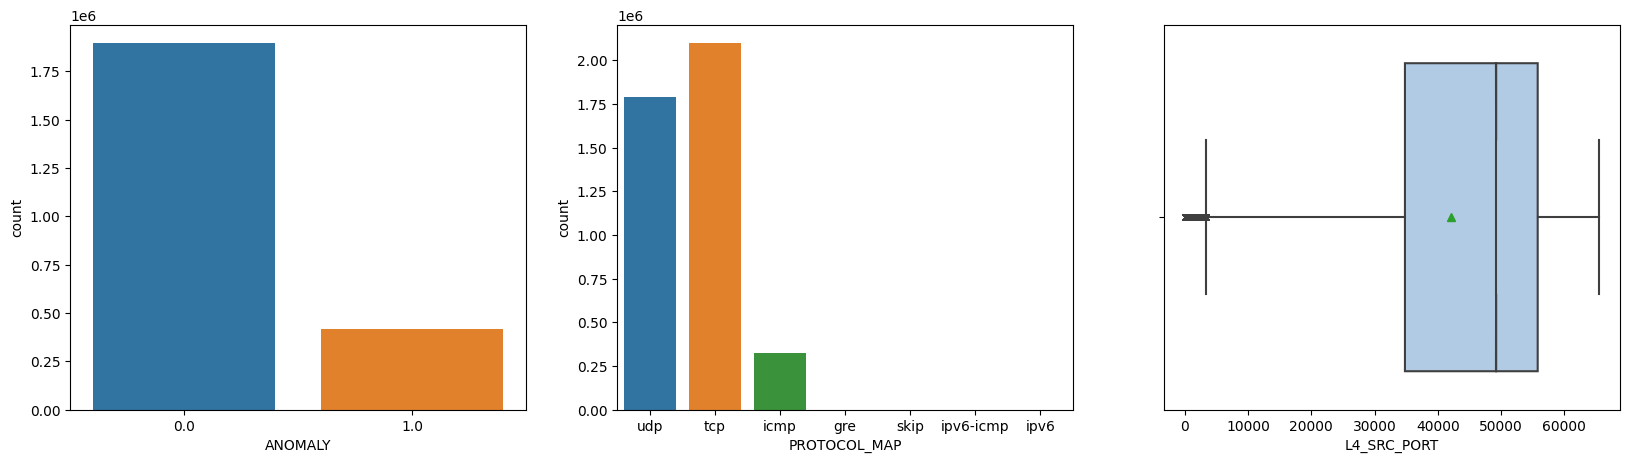

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# seaborn countplots
sns.countplot(x='ANOMALY', data=train_df, ax=axs[0])

# Seaborn countplot for the 'PROTOCOL_MAP' column, with enough space for the labels
sns.countplot(x='PROTOCOL_MAP', data=train_df, ax=axs[1])

# Boxplot for L4_SRC_PORT to undestand the distribution of the data
sns.boxplot(
    x='L4_SRC_PORT', data=train_df, ax=axs[2],
    notch=True, showcaps=True,
    flierprops={"marker": "x"}, # Change the outlier marker
    showmeans=True, # Show the mean
    boxprops={"facecolor": (.4, .6, .8, .5)},
  )

### 3.2 Unique hosts in dataset

Knowing the amount of unique hosts in the dataset is important to understand the size of the dataset since I expect that a bigger dataset will be more difficult to train properly.

In [28]:
# Find unique hosts (IP addresses) in the train and test data
train_src_hosts = train_df['IPV4_SRC_ADDR'].unique()
train_dst_hosts = train_df['IPV4_DST_ADDR'].unique()
train_hosts = np.union1d(train_src_hosts, train_dst_hosts)

# For each host, count the number of flows
print('Number of unique hosts in the train data: ', len(train_hosts))

# Find unique hosts (IP addresses) in the train and test data
test_src_hosts = test_df['IPV4_SRC_ADDR'].unique()
test_dst_hosts = test_df['IPV4_DST_ADDR'].unique()
test_hosts = np.union1d(test_src_hosts, test_dst_hosts)

# Floor ratio of hosts in test data that are not in train data
ratio = math.floor((1.0-len(test_hosts)/len(train_hosts)) * 100)

# For each host, count the number of flows
print("Number of unique hosts in the test data: {} (~{}% smaller)".format(len(test_hosts), ratio))


Number of unique hosts in the train data:  79085
Number of unique hosts in the test data: 62914 (~20% smaller)
